In [1]:
import re
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import contractions
from spellchecker import SpellChecker
import emoji
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, VotingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, ComplementNB, MultinomialNB
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score
from imblearn.over_sampling import SMOTE
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from add_features import medication_score, add_tweet_info
import eli5



### Importação dos datasets

- `df_train`: dataset de treino
- `df_test`: dataset de teste

In [2]:
df_train = pd.read_csv('task1_training.csv', delimiter = '\t')
df_test = pd.read_csv('task1_testing.csv', delimiter = '\t')


In [3]:
print(len(df_train))
print(len(df_test))

55419
13853


In [4]:
print(df_train['class'].value_counts())
print()
print(df_test['label'].value_counts())


class
0    55273
1      146
Name: count, dtype: int64

label
0    13817
1       36
Name: count, dtype: int64


### Pré processamento do texto

Processamento básico:

- minúsculas
- remover urls
- remover usernames
- remover pontuaçao repetida (exemplo: 'YES!!!' -> 'YES!')
- separar pontuação
- remover símbolos •‘’“”
- remover &amp &lt &gt
- remover #

In [5]:
df_train.tweet[3]

"I'm fine. They also just started me on pitocin to help me dilate faster so it shouldn't be long! Ready to have this baby!!! 🙂"

In [21]:
from process import BasicPreprocessor

processing = BasicPreprocessor()
processing.preprocess(df_train, 'tweet')
processing.preprocess(df_test, 'tweet')

In [22]:
df_train.tweet[3]

'i am fine. they also just started me on pitocin to help me dilate faster so it should not be long! ready to have this baby! '

In [15]:
import spacy
import scispacy
nlp = spacy.load("en_core_sci_lg")
nlp.add_pipe()
doc = nlp("Alterations in the hypocretin receptor 2 and preprohypocretin genes produce narcolepsy in some animals.")

ModuleNotFoundError: No module named 'scispacy'

In [14]:
print(doc.ents)

(Alterations, hypocretin receptor 2, preprohypocretin genes, narcolepsy, animals)


#### Tokenization + lemmatization

In [23]:
def lemma_tokenizer(text):
    res = list()

    #criar tokens
    tokens = word_tokenize(text)

    #lemmatizer
    lemmatizer = WordNetLemmatizer()
    for token in tokens:
        res.append(lemmatizer.lemmatize(token))
    return res


df_train['tweet'] = df_train['tweet'].apply(lemma_tokenizer)
df_test['tweet'] = df_test['tweet'].apply(lemma_tokenizer)

In [24]:
df_train.tweet[35]

['pixie',
 'is',
 'slowly',
 'learning',
 'going',
 'on',
 'walk',
 ',',
 'which',
 'she',
 'is',
 'super',
 'excited',
 'about',
 'it',
 'is',
 'so',
 'fun',
 'to',
 'watch',
 '!']

#### Remoçao de stopwords

In [25]:
#remove stopwords
def remove_stopwords(original_sentence):
    stop_words = set(stopwords.words('english'))
    filtered_sentence = list()

    for word in original_sentence:
        if word not in stop_words:
            filtered_sentence.append(word)

    return filtered_sentence
    

df_train['tweet'] = df_train['tweet'].apply(remove_stopwords)
df_test['tweet'] = df_test['tweet'].apply(remove_stopwords)

In [26]:
df_train.tweet[35]

['pixie',
 'slowly',
 'learning',
 'going',
 'walk',
 ',',
 'super',
 'excited',
 'fun',
 'watch',
 '!']

### Geração de novas features

Serão acrescentadas posteriormente à matriz do tfidf

In [27]:
medication_score(df_train,'medication_list.txt')
medication_score(df_test,'medication_list.txt')


,tweet_id,user_id,tweet,created_at,label,medication_score
0,502548414362841091,445019339,"[caydens, already, starting, open, eye, !, ane...",2014-08-21,0,0
1,557183572713676800,1485346748,"[johnny, cash, kind, mornin]",2015-01-19,0,0
2,442493939493261313,285855751,[chest],2014-03-09,0,0
3,499670327299805186,2421157857,"[sumn, slight]",2014-08-13,0,0
4,667265159753170944,1087305673,"[never, ever, excited, see, adelanto, .]",2015-11-19,0,0
...,...,...,...,...,...,...
13848,765601444678475778,1143892999,[go],2016-08-16,0,0
13849,821462917086183425,4745862650,"[jamie, foxx, movie, wa, coo, ,, see, relation...",2017-01-17,0,0
13850,870832539094491136,429115374,"[always, protect, son, ,, ill, damned, anyone,...",2017-06-03,0,0
13851,648522498984816640,1465089974,"[baby, kicking, strong, past, day, adriene, fi...",2015-09-28,0,0


In [28]:
df_train.head(10)

,tweet_id,user_id,tweet,created_at,class,medication_score
0,854534152070279168,2147874931,"[new, anti, anxiety, med, make, sleepy, sure, ...",2017-04-19,1,0
1,794036802378035200,1427054106,"[try, vitamin, olivia, !, hudson, ha, taken, v...",2016-11-03,1,2
2,832808092253319169,2147874931,"[toby, set, humidifier, room, practically, chu...",2017-02-18,1,0
3,703545681366097920,1465089974,"[fine, ., also, started, pitocin, help, dilate...",2016-02-27,1,1
4,800367699758977024,1427054106,"[take, prenatals, ,, people, back, day, think,...",2016-11-20,1,0
5,889880546679152640,738847850096910336,"[try, generic, (, wal, mart, brand, ), prilose...",2017-07-25,1,0
6,590750866971459584,60440414,"[sucked, back, much, entonox, labour, massive,...",2015-04-22,1,0
7,694693104939499521,208231808,"[explain, gmo, insulin, poison, ?, without, ,,...",2016-02-03,1,1
8,651201426274684929,21752467,"[stephanie, sound, like, need, decongestant, !]",2015-10-06,1,1
9,625285153552793600,70483719,"[yep, ., antibiotic, prayer, pass, doe, spread...",2015-07-26,1,1


In [29]:
type(df_train['medication_score'])
type(df_test['medication_score'])

pandas.core.series.Series

### TF-IDF

In [30]:
#criaçao de X_train, y_train, X_test, y_test

X_train = df_train['tweet']
y_train = df_train['class']

X_test = df_test['tweet']
y_test = df_test['label']

In [31]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (55419,)
X_test shape:  (13853,)
y_train shape:  (55419,)
y_test shape:  (13853,)


In [32]:
#mindf e maxdf
#tweet tokenizer - nltk
#cross_val_score no sklear.model_selection
#hyperparameters
#gridsearchCV

#rf, nb, logistic regression, multilayer perception

In [33]:
def dummy_tokenizer(text):
    return text

In [34]:
# pipeline = Pipeline([
#     ('tfidf', TfidfVectorizer(tokenizer= dummy_tokenizer, stop_words='english', lowercase=False)),       # Step 1: Apply TF-IDF vectorization
#     ('select_percentile', SelectPercentile(percentile=50))  # Step 2: Select top 50% features
# ])

In [35]:
tfidf = TfidfVectorizer(tokenizer= dummy_tokenizer, stop_words='english', lowercase=False)  

In [36]:
tfidf

TfidfVectorizer(lowercase=False, stop_words='english',
                tokenizer=<function dummy_tokenizer at 0x00000163A05E2290>)

In [37]:
# Fit and transform the training data
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = tfidf.transform(X_test)


c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


#### Adicionar medication_scores ao tfidf

In [38]:
import scipy as sp
#add medication score
new_train = [[x] for x in df_train['medication_score'].tolist()]
new_test = [[x] for x in df_test['medication_score'].tolist()]

X_train_tfidf = sp.sparse.hstack((X_train_tfidf, new_train))
X_test_tfidf = sp.sparse.hstack((X_test_tfidf, new_test))

In [39]:
for i in tfidf.get_feature_names_out():
    print(i)

!
#
$
%
&
(
)
*
+
+=++=
+a
+hello
+pound
+tax
+week
+win
+yrs
,
.
..
...
.a
.already
.am
.and
.andand
.as
.before
.bg
.but
.by
.colt
.drink
.enter
.even
.everything
.except
.exhausting
.expecting
.farm
.followers
.going
.have
.hm
.i
.in
.iphone
.it
.its
.knowing
.leaves
.linkin
.little
.many
.menor
.milf
.mini
.my
.nah
.needs
.ninja
.no
.nobody
.not
.obviously
.ok
.oops
.or
.org
.our
.pages
.place
.pretty
.quickly
.realms
.reminding
.rock
.s
.she
.since
.so
.some
.something
.still
.stuff
.that
.the
.they
.to
.too
.uh
.uhh
.upon
.watching
.we
.well
.what
.why
.with
.without
.wtf
.yay
.yes
.you
.yup
/
:
:lisa
:looks
;
<
=
=overstimulated
>
?
@
[
\
]
^
^^
^^^^
^he
a++++
a.
a.surprise
aa
aab
aahaha
aaliyah
aandd
aande
aandm
aandp
aandw
aargh
aaron
aaw
aaye
ab
abandon
abandoned
abbey
abbi
abbreviates
abbreviating
abbreviation
abby
abc
abcmouse
abdomen
abdominal
abduction
abear
abed
abel
abfab
abh
abigail
abigale
ability
abit
able
abnormal
abolished
abolishes
abort
aborted
abortion
abou
abou

In [40]:
# feature_names = tfidf.get_feature_names_out()

# import pandas as pd
# df = pd.DataFrame(X_train_tfidf.todense(), columns=feature_names)
# df = pd.concat([df, df_train['class']], axis = 1)
# # df.to_csv('tfidf_train.csv', index=False)


### SVM

In [46]:
clf_svm = LinearSVC(C=10,class_weight='balanced', loss='squared_hinge', penalty='l2')
clf_svm.fit(X_train_tfidf, y_train)
y_pred_svm = clf_svm.predict(X_test_tfidf)

print('Classification Report')
print(classification_report(y_test,y_pred_svm))


Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       0.87      0.56      0.68        36

    accuracy                           1.00     13853
   macro avg       0.93      0.78      0.84     13853
weighted avg       1.00      1.00      1.00     13853



In [23]:
from sklearn.metrics import make_scorer, f1_score
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
my_f1_scorer = make_scorer(f1_score, pos_label = 1)
scores_f1 = cross_val_score(clf_svm, X_train_tfidf, y_train, scoring = my_f1_scorer, cv = skf)
print(scores_f1)
print(scores_f1.mean())
y_pred_svm = clf_svm.predict(X_test_tfidf)
print(classification_report(y_test,y_pred_svm))

[0.75862069 0.52173913 0.75       0.75862069 0.53846154 0.5
 0.57142857 0.71428571 0.64285714 0.66666667]
0.6422680143444761
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       0.84      0.72      0.78        36

    accuracy                           1.00     13853
   macro avg       0.92      0.86      0.89     13853
weighted avg       1.00      1.00      1.00     13853



In [24]:
param_grid = {'C': [1, 10, 100, 1000],
              'loss': ['hinge','squared_hinge'],
              'penalty':['l1','l2'],
              'class_weight':['balanced',None]
              }

grid_svm = GridSearchCV(LinearSVC(),param_grid, verbose=3, cv=10)
grid_svm.fit(X_train_tfidf, y_train)
y_pred_grid_svm = grid_svm.predict(X_test_tfidf)
print(grid_svm.best_estimator_)
print(classification_report(y_test,y_pred_grid_svm))

Fitting 10 folds for each of 32 candidates, totalling 320 fits
[CV 1/10] END C=1, class_weight=balanced, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 2/10] END C=1, class_weight=balanced, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 3/10] END C=1, class_weight=balanced, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 4/10] END C=1, class_weight=balanced, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 5/10] END C=1, class_weight=balanced, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 6/10] END C=1, class_weight=balanced, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 7/10] END C=1, class_weight=balanced, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 8/10] END C=1, class_weight=balanced, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 9/10] END C=1, class_weight=balanced, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 10/10] END C=1, class_weight=balanced, loss=hinge, penalty=l1;, score

c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END C=1, class_weight=balanced, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 8/10] END C=1, class_weight=balanced, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 9/10] END C=1, class_weight=balanced, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s


c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END C=1, class_weight=balanced, loss=hinge, penalty=l2;, score=0.999 total time=   0.0s
[CV 1/10] END C=1, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 2/10] END C=1, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 3/10] END C=1, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 4/10] END C=1, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 5/10] END C=1, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 6/10] END C=1, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 7/10] END C=1, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 8/10] END C=1, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 9/10] END C=1, class_weight=balanced, loss=squared_hinge, penalty

c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END C=1, class_weight=None, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 10/10] END C=1, class_weight=None, loss=hinge, penalty=l2;, score=0.999 total time=   0.0s
[CV 1/10] END C=1, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 2/10] END C=1, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 3/10] END C=1, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 4/10] END C=1, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 5/10] END C=1, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 6/10] END C=1, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 7/10] END C=1, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 8/10] END C=1, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 9/10] E

c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END C=10, class_weight=balanced, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 2/10] END C=10, class_weight=balanced, loss=hinge, penalty=l2;, score=0.999 total time=   0.0s
[CV 3/10] END C=10, class_weight=balanced, loss=hinge, penalty=l2;, score=0.999 total time=   0.0s


c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END C=10, class_weight=balanced, loss=hinge, penalty=l2;, score=0.999 total time=   0.0s
[CV 5/10] END C=10, class_weight=balanced, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 6/10] END C=10, class_weight=balanced, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s


c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END C=10, class_weight=balanced, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 8/10] END C=10, class_weight=balanced, loss=hinge, penalty=l2;, score=0.999 total time=   0.0s
[CV 9/10] END C=10, class_weight=balanced, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s


c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END C=10, class_weight=balanced, loss=hinge, penalty=l2;, score=0.999 total time=   0.0s
[CV 1/10] END C=10, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 2/10] END C=10, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 3/10] END C=10, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 4/10] END C=10, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 5/10] END C=10, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 6/10] END C=10, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 7/10] END C=10, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 8/10] END C=10, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 9/10] END C=10, class_weight=balanced, loss=squared_hing

c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END C=10, class_weight=None, loss=hinge, penalty=l2;, score=0.999 total time=   0.0s
[CV 3/10] END C=10, class_weight=None, loss=hinge, penalty=l2;, score=0.999 total time=   0.0s
[CV 4/10] END C=10, class_weight=None, loss=hinge, penalty=l2;, score=0.999 total time=   0.0s


c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END C=10, class_weight=None, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 6/10] END C=10, class_weight=None, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 7/10] END C=10, class_weight=None, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 8/10] END C=10, class_weight=None, loss=hinge, penalty=l2;, score=0.999 total time=   0.0s
[CV 9/10] END C=10, class_weight=None, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 10/10] END C=10, class_weight=None, loss=hinge, penalty=l2;, score=0.999 total time=   0.0s
[CV 1/10] END C=10, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 2/10] END C=10, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 3/10] END C=10, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s


c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END C=10, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 5/10] END C=10, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 6/10] END C=10, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 7/10] END C=10, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 8/10] END C=10, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 9/10] END C=10, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 10/10] END C=10, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 1/10] END C=10, class_weight=None, loss=squared_hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 2/10] END C=10, class_weight=None, loss=squared_hinge, penalty=l2;, score=0.999 total time=   0.0s
[CV 3/10] END C=10, class_weight=None, loss=squared_hinge, penalty=l2;, score=0.999 to

c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END C=100, class_weight=balanced, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 4/10] END C=100, class_weight=balanced, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 5/10] END C=100, class_weight=balanced, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 6/10] END C=100, class_weight=balanced, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s


c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END C=100, class_weight=balanced, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 8/10] END C=100, class_weight=balanced, loss=hinge, penalty=l2;, score=0.999 total time=   0.0s
[CV 9/10] END C=100, class_weight=balanced, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 10/10] END C=100, class_weight=balanced, loss=hinge, penalty=l2;, score=0.999 total time=   0.0s


c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END C=100, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 2/10] END C=100, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 3/10] END C=100, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 4/10] END C=100, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 5/10] END C=100, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 6/10] END C=100, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 7/10] END C=100, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 8/10] END C=100, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 9/10] END C=100, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 10/10] END C=100, class_weight=balanced, l

c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END C=100, class_weight=balanced, loss=squared_hinge, penalty=l2;, score=0.999 total time=   0.0s
[CV 4/10] END C=100, class_weight=balanced, loss=squared_hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 5/10] END C=100, class_weight=balanced, loss=squared_hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 6/10] END C=100, class_weight=balanced, loss=squared_hinge, penalty=l2;, score=0.998 total time=   0.0s


c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\d

[CV 7/10] END C=100, class_weight=balanced, loss=squared_hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 8/10] END C=100, class_weight=balanced, loss=squared_hinge, penalty=l2;, score=0.999 total time=   0.0s
[CV 9/10] END C=100, class_weight=balanced, loss=squared_hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 10/10] END C=100, class_weight=balanced, loss=squared_hinge, penalty=l2;, score=0.999 total time=   0.0s
[CV 1/10] END C=100, class_weight=None, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 2/10] END C=100, class_weight=None, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 3/10] END C=100, class_weight=None, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 4/10] END C=100, class_weight=None, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 5/10] END C=100, class_weight=None, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 6/10] END C=100, class_weight=None, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV

c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END C=100, class_weight=None, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 3/10] END C=100, class_weight=None, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 4/10] END C=100, class_weight=None, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s


c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END C=100, class_weight=None, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 6/10] END C=100, class_weight=None, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 7/10] END C=100, class_weight=None, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 8/10] END C=100, class_weight=None, loss=hinge, penalty=l2;, score=0.999 total time=   0.0s


c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END C=100, class_weight=None, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 10/10] END C=100, class_weight=None, loss=hinge, penalty=l2;, score=0.999 total time=   0.0s
[CV 1/10] END C=100, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 2/10] END C=100, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 3/10] END C=100, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 4/10] END C=100, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 5/10] END C=100, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 6/10] END C=100, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 7/10] END C=100, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 8/10] END C=100, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time

c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END C=100, class_weight=None, loss=squared_hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 2/10] END C=100, class_weight=None, loss=squared_hinge, penalty=l2;, score=0.999 total time=   0.0s
[CV 3/10] END C=100, class_weight=None, loss=squared_hinge, penalty=l2;, score=0.999 total time=   0.0s
[CV 4/10] END C=100, class_weight=None, loss=squared_hinge, penalty=l2;, score=0.998 total time=   0.0s


c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END C=100, class_weight=None, loss=squared_hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 6/10] END C=100, class_weight=None, loss=squared_hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 7/10] END C=100, class_weight=None, loss=squared_hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 8/10] END C=100, class_weight=None, loss=squared_hinge, penalty=l2;, score=0.999 total time=   0.0s


c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END C=100, class_weight=None, loss=squared_hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 10/10] END C=100, class_weight=None, loss=squared_hinge, penalty=l2;, score=0.999 total time=   0.0s
[CV 1/10] END C=1000, class_weight=balanced, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 2/10] END C=1000, class_weight=balanced, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 3/10] END C=1000, class_weight=balanced, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 4/10] END C=1000, class_weight=balanced, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 5/10] END C=1000, class_weight=balanced, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 6/10] END C=1000, class_weight=balanced, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 7/10] END C=1000, class_weight=balanced, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 8/10] END C=1000, class_weight=balanced, loss=hinge, penalty=l1;, score=nan total time=   0.0s

c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END C=1000, class_weight=balanced, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 2/10] END C=1000, class_weight=balanced, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 3/10] END C=1000, class_weight=balanced, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 4/10] END C=1000, class_weight=balanced, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s


c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END C=1000, class_weight=balanced, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 6/10] END C=1000, class_weight=balanced, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 7/10] END C=1000, class_weight=balanced, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 8/10] END C=1000, class_weight=balanced, loss=hinge, penalty=l2;, score=0.999 total time=   0.0s
[CV 9/10] END C=1000, class_weight=balanced, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 10/10] END C=1000, class_weight=balanced, loss=hinge, penalty=l2;, score=0.999 total time=   0.0s
[CV 1/10] END C=1000, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 2/10] END C=1000, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 3/10] END C=1000, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 4/10] END C=1000, class_weight=balanced, loss=squared_hinge, penalty

c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END C=1000, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 10/10] END C=1000, class_weight=balanced, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 1/10] END C=1000, class_weight=balanced, loss=squared_hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 2/10] END C=1000, class_weight=balanced, loss=squared_hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 3/10] END C=1000, class_weight=balanced, loss=squared_hinge, penalty=l2;, score=0.998 total time=   0.0s


c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END C=1000, class_weight=balanced, loss=squared_hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 5/10] END C=1000, class_weight=balanced, loss=squared_hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 6/10] END C=1000, class_weight=balanced, loss=squared_hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 7/10] END C=1000, class_weight=balanced, loss=squared_hinge, penalty=l2;, score=0.998 total time=   0.0s


c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END C=1000, class_weight=balanced, loss=squared_hinge, penalty=l2;, score=0.999 total time=   0.0s
[CV 9/10] END C=1000, class_weight=balanced, loss=squared_hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 10/10] END C=1000, class_weight=balanced, loss=squared_hinge, penalty=l2;, score=0.999 total time=   0.0s
[CV 1/10] END C=1000, class_weight=None, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 2/10] END C=1000, class_weight=None, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 3/10] END C=1000, class_weight=None, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 4/10] END C=1000, class_weight=None, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 5/10] END C=1000, class_weight=None, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 6/10] END C=1000, class_weight=None, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 7/10] END C=1000, class_weight=None, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 8/1

c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\d

[CV 1/10] END C=1000, class_weight=None, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 2/10] END C=1000, class_weight=None, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 3/10] END C=1000, class_weight=None, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 4/10] END C=1000, class_weight=None, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s


c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END C=1000, class_weight=None, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 6/10] END C=1000, class_weight=None, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 7/10] END C=1000, class_weight=None, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 8/10] END C=1000, class_weight=None, loss=hinge, penalty=l2;, score=0.999 total time=   0.0s


c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END C=1000, class_weight=None, loss=hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 10/10] END C=1000, class_weight=None, loss=hinge, penalty=l2;, score=0.999 total time=   0.0s
[CV 1/10] END C=1000, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 2/10] END C=1000, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 3/10] END C=1000, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 4/10] END C=1000, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 5/10] END C=1000, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 6/10] END C=1000, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 7/10] END C=1000, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan total time=   0.0s
[CV 8/10] END C=1000, class_weight=None, loss=squared_hinge, penalty=l1;, score=nan 

c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END C=1000, class_weight=None, loss=squared_hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 3/10] END C=1000, class_weight=None, loss=squared_hinge, penalty=l2;, score=0.999 total time=   0.0s
[CV 4/10] END C=1000, class_weight=None, loss=squared_hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 5/10] END C=1000, class_weight=None, loss=squared_hinge, penalty=l2;, score=0.998 total time=   0.0s


c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END C=1000, class_weight=None, loss=squared_hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 7/10] END C=1000, class_weight=None, loss=squared_hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 8/10] END C=1000, class_weight=None, loss=squared_hinge, penalty=l2;, score=0.999 total time=   0.0s
[CV 9/10] END C=1000, class_weight=None, loss=squared_hinge, penalty=l2;, score=0.998 total time=   0.0s
[CV 10/10] END C=1000, class_weight=None, loss=squared_hinge, penalty=l2;, score=0.999 total time=   0.0s
LinearSVC(C=10, class_weight='balanced')
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       0.87      0.56      0.68        36

    accuracy                           1.00     13853
   macro avg       0.93      0.78      0.84     13853
weighted avg       1.00      1.00      1.00     13853



c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
160 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    es

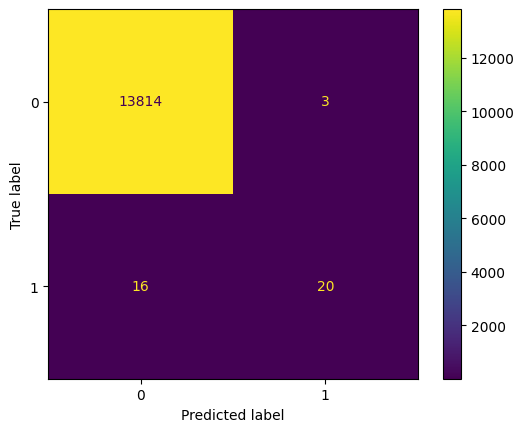

In [25]:
cm = confusion_matrix(y_test, y_pred_grid_svm, labels=clf_svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_svm.classes_)
disp.plot()

### Random forest

In [26]:
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train_tfidf, y_train)
y_pred_rf = clf_rf.predict(X_test_tfidf)

print('Classification Report')
print(classification_report(y_test,y_pred_rf))

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       1.00      0.28      0.43        36

    accuracy                           1.00     13853
   macro avg       1.00      0.64      0.72     13853
weighted avg       1.00      1.00      1.00     13853



In [33]:
param_grid = {'criterion':['gini','entropy','log_loss'],
              'max_features':['sqrt','log2',None],
              'class_weight':['balanced','balanced_subsample',None]
              }

grid_rf = GridSearchCV(RandomForestClassifier(),param_grid, verbose=3, cv=5)
grid_rf.fit(X_train_tfidf, y_train)
y_pred_grid_rf = grid_rf.predict(X_test_tfidf)
print(grid_rf.best_estimator_)
print(classification_report(y_test,y_pred_grid_rf))

Fitting 2 folds for each of 27 candidates, totalling 54 fits


KeyboardInterrupt: 

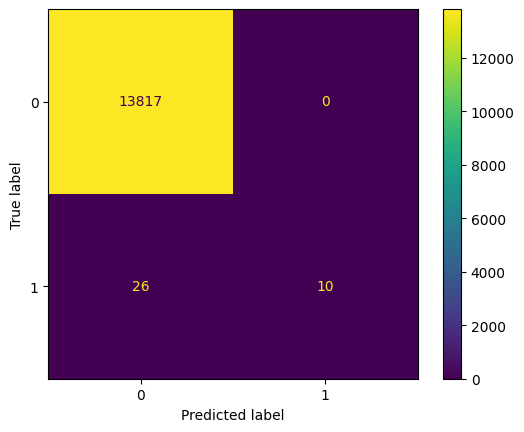

In [27]:
cm = confusion_matrix(y_test, y_pred_rf, labels=clf_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_rf.classes_)
disp.plot()

### Logistic Regression

In [48]:
clf_lr = LogisticRegression(C= 100, class_weight='balanced', solver='liblinear', max_iter=10000)
clf_lr.fit(X_train_tfidf, y_train)
y_pred_lr = clf_lr.predict(X_test_tfidf)

print('Classification Report')
print(classification_report(y_test,y_pred_lr))

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       0.90      0.75      0.82        36

    accuracy                           1.00     13853
   macro avg       0.95      0.87      0.91     13853
weighted avg       1.00      1.00      1.00     13853



In [49]:
print("Valores previstos: ", list(y_pred_lr))
print("Valores reais: " , list(y_test))
score = 0
for x,y in zip(list(y_pred_lr), list(y_test)):
    score +=1
    if x != y:
        print(score)

Valores previstos:  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [28]:
from sklearn.metrics import make_scorer, f1_score
my_f1_scorer = make_scorer(f1_score, pos_label = 1)
scores_f1 = cross_val_score(clf_lr, X_train_tfidf, y_train, scoring = my_f1_scorer, cv = 6)
print(scores_f1)
print(scores_f1.mean())

[0.69387755 0.68292683 0.52941176 0.60869565 0.74418605 0.7       ]
0.659849640613354


In [29]:
# print("Valores previstos: ", list(y_pred_lr))
# print("Valores reais: " , list(y_test))
# score = 0
# for x,y in zip(list(y_pred_lr), list(y_test)):
#     score +=1
#     if x != y:
#         print(score)

In [29]:
param_grid = {'C': [1, 10, 100, 1000],
              'class_weight': ['balanced', None],
              'solver': ['lbfgs', 'liblinear']}

grid_lr = GridSearchCV(LogisticRegression(max_iter=10000),param_grid, verbose=3, cv=5)
grid_lr.fit(X_train_tfidf, y_train)
y_pred_grid_lr = grid_lr.predict(X_test_tfidf)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END C=1, class_weight=balanced, solver=lbfgs;, score=0.998 total time=   0.2s
[CV 2/5] END C=1, class_weight=balanced, solver=lbfgs;, score=0.999 total time=   0.4s
[CV 3/5] END C=1, class_weight=balanced, solver=lbfgs;, score=0.997 total time=   0.3s
[CV 4/5] END C=1, class_weight=balanced, solver=lbfgs;, score=0.998 total time=   0.3s
[CV 5/5] END C=1, class_weight=balanced, solver=lbfgs;, score=0.998 total time=   0.2s
[CV 1/5] END C=1, class_weight=balanced, solver=liblinear;, score=0.998 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, solver=liblinear;, score=0.999 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, solver=liblinear;, score=0.997 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, solver=liblinear;, score=0.998 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, solver=liblinear;, score=0.998 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, solver=lbfgs

In [30]:
print(grid_lr.best_estimator_)
print(classification_report(y_test,y_pred_grid_lr))

LogisticRegression(C=1000, class_weight='balanced', max_iter=10000)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       0.88      0.61      0.72        36

    accuracy                           1.00     13853
   macro avg       0.94      0.81      0.86     13853
weighted avg       1.00      1.00      1.00     13853



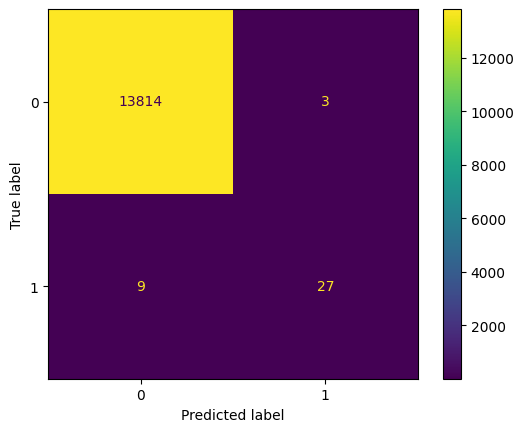

In [32]:
cm = confusion_matrix(y_test, y_pred_lr, labels=clf_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_lr.classes_)
disp.plot()

### Naive bayes

In [53]:
clf_nb = MultinomialNB()
clf_nb.fit(X_train_tfidf, y_train)
y_pred_nb = clf_nb.predict(X_test_tfidf)

print('Classification Report')
print(classification_report(y_test,y_pred_nb))

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       0.00      0.00      0.00        36

    accuracy                           1.00     13853
   macro avg       0.50      0.50      0.50     13853
weighted avg       0.99      1.00      1.00     13853



c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

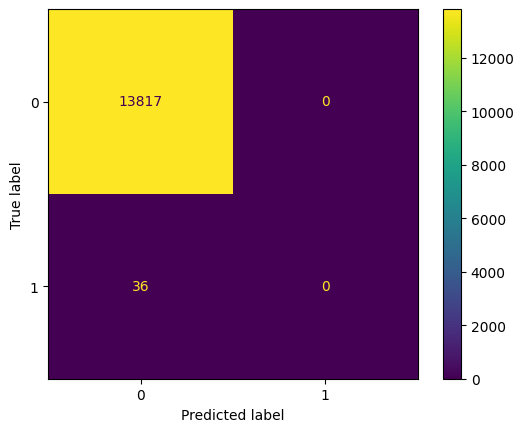

In [34]:
cm = confusion_matrix(y_test, y_pred_nb, labels=clf_nb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_nb.classes_)
disp.plot()

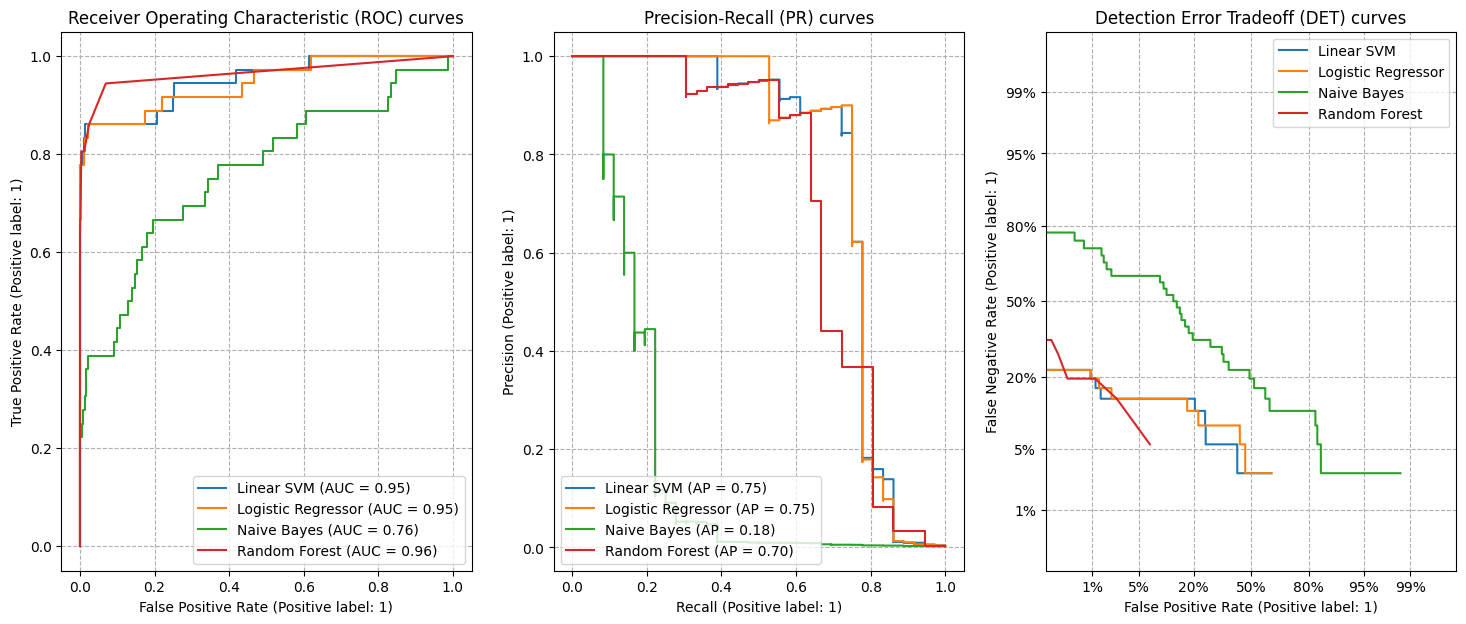

In [35]:


classifiers = {
    "Linear SVM": clf_svm,
    "Logistic Regressor": clf_lr,
    'Naive Bayes': clf_nb,
    'Random Forest': clf_rf
}

import matplotlib.pyplot as plt
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay, PrecisionRecallDisplay

fig, [ax_roc, ax_pr, ax_det] = plt.subplots(1, 3, figsize=(18, 7))

for name, clf in classifiers.items():
    clf.fit(X_train_tfidf, y_train)

    RocCurveDisplay.from_estimator(clf, X_test_tfidf, y_test, ax=ax_roc, name=name)
    PrecisionRecallDisplay.from_estimator(clf, X_test_tfidf, y_test, ax=ax_pr, name=name)
    DetCurveDisplay.from_estimator(clf, X_test_tfidf, y_test, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_pr.set_title("Precision-Recall (PR) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_pr.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

### Ensemble

In [36]:
eclf = VotingClassifier(estimators=[('svm', clf_svm), ('lr', clf_lr)],
                        voting='hard', weights=[2,4])
eclf.fit(X_train_tfidf,y_train)
y_eclf_pred = eclf.predict(X_test_tfidf)
print(classification_report(y_test, y_eclf_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       0.90      0.75      0.82        36

    accuracy                           1.00     13853
   macro avg       0.95      0.87      0.91     13853
weighted avg       1.00      1.00      1.00     13853



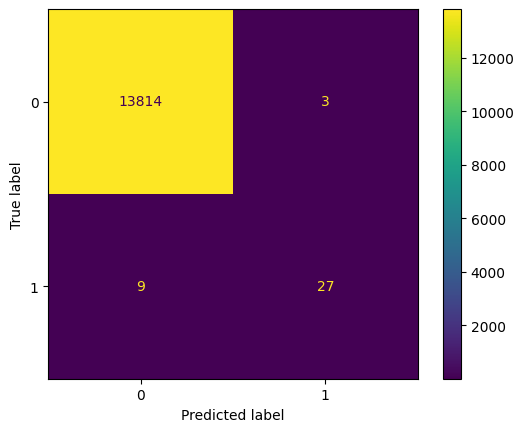

In [37]:
cm = confusion_matrix(y_test, y_eclf_pred, labels=eclf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=eclf.classes_)
disp.plot()

### MPLClassifier

In [38]:
clf_mpl = MLPClassifier()
clf_mpl.fit(X_train_tfidf, y_train)
y_pred_mlp = clf_mpl.predict(X_test_tfidf)

print('Classification Report')
print(classification_report(y_test,y_pred_mlp))

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       0.95      0.53      0.68        36

    accuracy                           1.00     13853
   macro avg       0.97      0.76      0.84     13853
weighted avg       1.00      1.00      1.00     13853



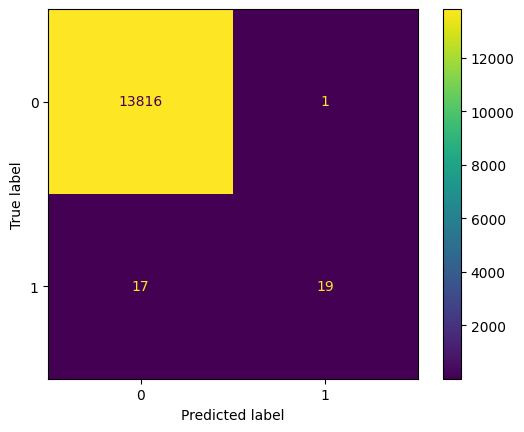

In [39]:
cm = confusion_matrix(y_test, y_pred_mlp, labels=clf_mpl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_mpl.classes_)
disp.plot()

In [40]:
print("Valores previstos: ", list(y_pred_mlp))
print("Valores reais: " , list(y_test))
score = 0
for x,y in zip(list(y_pred_mlp), list(y_test)):
    score +=1
    if x != y:
        print(score)

Valores previstos:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0